# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [14]:
import pandas as pd
import numpy as np
import requests
import tweepy # conda install -c conda-forge tweepy
import datetime
import os
import json
import matplotlib.pyplot as plt
import re
import seaborn as sns

%matplotlib inline



### constants

In [15]:
consumer_key = '5iby28w3W0sLaftOEeTnu9ca8'
consumer_secret = 'x7TAz4lKHDGibF6T5LXjl75T7yPvXcalB44CYzVHPY5y4hBeGI'
access_token = '4293960496-lwMzPHuLzw7wIvd79WcyNDB0Iz2zxdrq0WTgOfp'
access_secret = 'NKhbFjx60cwn9YN4uEAcJKmAQJPMOqOePkuEdoydtwCKw'


# To control sending api requests
SEND_API_REQUEST = True

### 1. Tweeter archive file

In [16]:
#load twitter-archive-enhanced.csv into twitter_archive_df
archive_df = pd.read_csv('twitter-archive-enhanced.csv')
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [17]:
archive_df.shape

(2356, 17)

### 2. Twitter image predictions


In [18]:
images = pd.read_csv('image-predictions.tsv', sep = '\t')
images.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [19]:
images.shape

(2075, 12)

In [20]:
# Connect
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

# When sending requests to Twitter API
# - use OAuth method
# - automaticlly wait for rate limits to replenish
# - print notification when Tweepy is waiting for rate limits to replenish
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# Testing
for tweet_id in archive_df.tweet_id:
    print(tweet_id)
    tweet_response = api.get_status(tweet_id, tweet_mode='extended')
    tweet_info = tweet_response._json  
    break
#tweet_info

892420643555336193


In [21]:
# Testing
tweet_info['id']
tweet_info['retweet_count']
tweet_info['favorite_count']
tweet_info['user']['followers_count']

9380275

In [22]:
# Import every tweet JSON data into 'tweet_json.txt' as a separate line
# wait for 15 minutes (automatically) each time the rate limit is hit 
# (for taking tweets data, the limit is 900 tweets per 15 minutes)

file_name = 'tweet_json.txt'

# Create a file, remove previous one if exists
#open(file_name, 'w').close()

# Create a file if it doesn't exist
if not os.path.isfile(file_name):
    open(file_name, 'w').close()

In [23]:
tweet_errors = {}
current_tweet_number = 0
tweet_data = []

if SEND_API_REQUEST:
    for tweet_id in archive_df.tweet_id:
        try:
            # Increment current_tweet_number
            current_tweet_number += 1

            # Start stamp
            print('-'*10)
            print('{} started at {}. Tweet_id -> {}'.format(current_tweet_number, datetime.datetime.now().time(), tweet_id))

            # Get request response
            tweet_response = api.get_status(tweet_id, tweet_mode='extended')
            tweet_info = tweet_response._json

            # Append to 'tweet_json.txt' file
            tweet_data.append(tweet_info)
            with open(file_name, 'w') as file:
                json.dump(tweet_data, file)

            # End stamp
            print('{} completed at {}'.format(current_tweet_number, datetime.datetime.now().time()))

            # Testing
            #if current_tweet_number > 50:
            #      break

        except Exception as e:
            # Record exceptions
            print(' -> {} EXCEPTION at {}'.format(current_tweet_number, datetime.datetime.now().time()))
            tweet_errors[str(tweet_id)] = str(e)

----------
1 started at 12:14:42.805827. Tweet_id -> 892420643555336193
1 completed at 12:14:42.988921
----------
2 started at 12:14:42.989313. Tweet_id -> 892177421306343426
2 completed at 12:14:43.177104
----------
3 started at 12:14:43.177501. Tweet_id -> 891815181378084864
3 completed at 12:14:43.359461
----------
4 started at 12:14:43.359810. Tweet_id -> 891689557279858688
4 completed at 12:14:43.542928
----------
5 started at 12:14:43.543378. Tweet_id -> 891327558926688256
5 completed at 12:14:43.724379
----------
6 started at 12:14:43.724773. Tweet_id -> 891087950875897856
6 completed at 12:14:43.901507
----------
7 started at 12:14:43.901997. Tweet_id -> 890971913173991426
7 completed at 12:14:44.116580
----------
8 started at 12:14:44.117035. Tweet_id -> 890729181411237888
8 completed at 12:14:44.300189
----------
9 started at 12:14:44.300610. Tweet_id -> 890609185150312448
9 completed at 12:14:44.514330
----------
10 started at 12:14:44.514765. Tweet_id -> 890240255349198849


80 completed at 12:14:58.993108
----------
81 started at 12:14:58.993528. Tweet_id -> 877316821321428993
81 completed at 12:14:59.197711
----------
82 started at 12:14:59.198143. Tweet_id -> 877201837425926144
82 completed at 12:14:59.489348
----------
83 started at 12:14:59.489770. Tweet_id -> 876838120628539392
83 completed at 12:14:59.733439
----------
84 started at 12:14:59.733857. Tweet_id -> 876537666061221889
84 completed at 12:14:59.965789
----------
85 started at 12:14:59.966213. Tweet_id -> 876484053909872640
85 completed at 12:15:00.198591
----------
86 started at 12:15:00.198977. Tweet_id -> 876120275196170240
86 completed at 12:15:00.389350
----------
87 started at 12:15:00.389772. Tweet_id -> 875747767867523072
87 completed at 12:15:00.586189
----------
88 started at 12:15:00.586651. Tweet_id -> 875144289856114688
88 completed at 12:15:00.826991
----------
89 started at 12:15:00.827445. Tweet_id -> 875097192612077568
89 completed at 12:15:01.037825
----------
90 started a

157 completed at 12:15:17.374724
----------
158 started at 12:15:17.375247. Tweet_id -> 861288531465048066
158 completed at 12:15:17.646691
----------
159 started at 12:15:17.647154. Tweet_id -> 861005113778896900
159 completed at 12:15:17.916824
----------
160 started at 12:15:17.917346. Tweet_id -> 860981674716409858
160 completed at 12:15:18.198479
----------
161 started at 12:15:18.198973. Tweet_id -> 860924035999428608
161 completed at 12:15:18.502477
----------
162 started at 12:15:18.502979. Tweet_id -> 860563773140209665
162 completed at 12:15:18.775068
----------
163 started at 12:15:18.775544. Tweet_id -> 860524505164394496
163 completed at 12:15:19.013838
----------
164 started at 12:15:19.014314. Tweet_id -> 860276583193509888
164 completed at 12:15:19.283796
----------
165 started at 12:15:19.284302. Tweet_id -> 860184849394610176
165 completed at 12:15:19.554364
----------
166 started at 12:15:19.554837. Tweet_id -> 860177593139703809
166 completed at 12:15:19.843685
----

234 completed at 12:15:38.601753
----------
235 started at 12:15:38.602264. Tweet_id -> 847617282490613760
235 completed at 12:15:38.869011
----------
236 started at 12:15:38.869484. Tweet_id -> 847606175596138505
236 completed at 12:15:39.142621
----------
237 started at 12:15:39.143140. Tweet_id -> 847251039262605312
237 completed at 12:15:39.451075
----------
238 started at 12:15:39.451646. Tweet_id -> 847157206088847362
238 completed at 12:15:39.723954
----------
239 started at 12:15:39.724497. Tweet_id -> 847116187444137987
239 completed at 12:15:39.996698
----------
240 started at 12:15:39.997201. Tweet_id -> 846874817362120707
240 completed at 12:15:40.322437
----------
241 started at 12:15:40.322942. Tweet_id -> 846514051647705089
241 completed at 12:15:40.641718
----------
242 started at 12:15:40.642246. Tweet_id -> 846505985330044928
242 completed at 12:15:40.955513
----------
243 started at 12:15:40.956001. Tweet_id -> 846153765933735936
243 completed at 12:15:41.230003
----

311 completed at 12:16:02.077509
----------
312 started at 12:16:02.077995. Tweet_id -> 835297930240217089
312 completed at 12:16:02.426499
----------
313 started at 12:16:02.427029. Tweet_id -> 835264098648616962
313 completed at 12:16:02.782514
----------
314 started at 12:16:02.783011. Tweet_id -> 835246439529840640
314 completed at 12:16:03.142165
----------
315 started at 12:16:03.142667. Tweet_id -> 835172783151792128
315 completed at 12:16:03.458954
----------
316 started at 12:16:03.459417. Tweet_id -> 835152434251116546
316 completed at 12:16:03.797565
----------
317 started at 12:16:03.798057. Tweet_id -> 834931633769889797
317 completed at 12:16:04.110825
----------
318 started at 12:16:04.111314. Tweet_id -> 834786237630337024
318 completed at 12:16:04.457647
----------
319 started at 12:16:04.458141. Tweet_id -> 834574053763584002
319 completed at 12:16:04.821564
----------
320 started at 12:16:04.822091. Tweet_id -> 834477809192075265
320 completed at 12:16:05.223167
----

388 completed at 12:16:30.198282
----------
389 started at 12:16:30.198773. Tweet_id -> 826598365270007810
389 completed at 12:16:30.575878
----------
390 started at 12:16:30.576361. Tweet_id -> 826476773533745153
390 completed at 12:16:30.943554
----------
391 started at 12:16:30.944030. Tweet_id -> 826240494070030336
391 completed at 12:16:31.300377
----------
392 started at 12:16:31.300941. Tweet_id -> 826204788643753985
392 completed at 12:16:31.667612
----------
393 started at 12:16:31.668112. Tweet_id -> 826115272272650244
393 completed at 12:16:32.061132
----------
394 started at 12:16:32.061574. Tweet_id -> 825876512159186944
394 completed at 12:16:32.460639
----------
395 started at 12:16:32.461149. Tweet_id -> 825829644528148480
395 completed at 12:16:32.820699
----------
396 started at 12:16:32.821272. Tweet_id -> 825535076884762624
396 completed at 12:16:33.200197
----------
397 started at 12:16:33.200744. Tweet_id -> 825147591692263424
397 completed at 12:16:33.569572
----

465 completed at 12:17:01.271837
----------
466 started at 12:17:01.272391. Tweet_id -> 817181837579653120
466 completed at 12:17:01.725322
----------
467 started at 12:17:01.725811. Tweet_id -> 817171292965273600
467 completed at 12:17:02.182945
----------
468 started at 12:17:02.183434. Tweet_id -> 817120970343411712
468 completed at 12:17:02.613288
----------
469 started at 12:17:02.613771. Tweet_id -> 817056546584727552
469 completed at 12:17:03.054628
----------
470 started at 12:17:03.055132. Tweet_id -> 816829038950027264
470 completed at 12:17:03.505996
----------
471 started at 12:17:03.506458. Tweet_id -> 816816676327063552
471 completed at 12:17:03.939472
----------
472 started at 12:17:03.939902. Tweet_id -> 816697700272001025
472 completed at 12:17:04.354169
----------
473 started at 12:17:04.354630. Tweet_id -> 816450570814898180
473 completed at 12:17:04.789989
----------
474 started at 12:17:04.790487. Tweet_id -> 816336735214911488
474 completed at 12:17:05.308810
----

542 completed at 12:17:36.474464
----------
543 started at 12:17:36.474942. Tweet_id -> 806219024703037440
543 completed at 12:17:37.001610
----------
544 started at 12:17:37.002112. Tweet_id -> 805958939288408065
544 completed at 12:17:37.489715
----------
545 started at 12:17:37.490235. Tweet_id -> 805932879469572096
545 completed at 12:17:37.971044
----------
546 started at 12:17:37.971534. Tweet_id -> 805826884734976000
546 completed at 12:17:38.486219
----------
547 started at 12:17:38.486705. Tweet_id -> 805823200554876929
547 completed at 12:17:38.949973
----------
548 started at 12:17:38.950468. Tweet_id -> 805520635690676224
548 completed at 12:17:39.437545
----------
549 started at 12:17:39.438027. Tweet_id -> 805487436403003392
549 completed at 12:17:39.902301
----------
550 started at 12:17:39.902769. Tweet_id -> 805207613751304193
550 completed at 12:17:40.402886
----------
551 started at 12:17:40.403434. Tweet_id -> 804738756058218496
551 completed at 12:17:40.895852
----

619 completed at 12:18:15.773058
----------
620 started at 12:18:15.773544. Tweet_id -> 796149749086875649
620 completed at 12:18:16.271883
----------
621 started at 12:18:16.272361. Tweet_id -> 796125600683540480
621 completed at 12:18:16.833837
----------
622 started at 12:18:16.834321. Tweet_id -> 796116448414461957
622 completed at 12:18:17.355958
----------
623 started at 12:18:17.356445. Tweet_id -> 796080075804475393
623 completed at 12:18:17.906415
----------
624 started at 12:18:17.906885. Tweet_id -> 796031486298386433
624 completed at 12:18:18.431007
----------
625 started at 12:18:18.431528. Tweet_id -> 795464331001561088
625 completed at 12:18:18.942073
----------
626 started at 12:18:18.942584. Tweet_id -> 795400264262053889
626 completed at 12:18:19.469757
----------
627 started at 12:18:19.470257. Tweet_id -> 795076730285391872
627 completed at 12:18:20.001401
----------
628 started at 12:18:20.001872. Tweet_id -> 794983741416415232
628 completed at 12:18:20.545611
----

696 completed at 12:18:58.532830
----------
697 started at 12:18:58.533304. Tweet_id -> 786664955043049472
697 completed at 12:18:59.108044
----------
698 started at 12:18:59.108534. Tweet_id -> 786595970293370880
698 completed at 12:18:59.662562
----------
699 started at 12:18:59.663065. Tweet_id -> 786363235746385920
699 completed at 12:19:00.198570
----------
700 started at 12:19:00.199077. Tweet_id -> 786286427768250368
700 completed at 12:19:00.767137
----------
701 started at 12:19:00.767629. Tweet_id -> 786233965241827333
701 completed at 12:19:01.352802
----------
702 started at 12:19:01.353301. Tweet_id -> 786051337297522688
702 completed at 12:19:01.935882
----------
703 started at 12:19:01.936342. Tweet_id -> 786036967502913536
703 completed at 12:19:02.544375
----------
704 started at 12:19:02.544904. Tweet_id -> 785927819176054784
704 completed at 12:19:03.088446
----------
705 started at 12:19:03.088927. Tweet_id -> 785872687017132033
705 completed at 12:19:03.683652
----

773 completed at 12:19:44.351753
----------
774 started at 12:19:44.352268. Tweet_id -> 776249906839351296
774 completed at 12:19:44.975805
----------
775 started at 12:19:44.976315. Tweet_id -> 776218204058357768
775 completed at 12:19:45.569064
----------
776 started at 12:19:45.569513. Tweet_id -> 776201521193218049
776 completed at 12:19:46.183046
----------
777 started at 12:19:46.183495. Tweet_id -> 776113305656188928
777 completed at 12:19:46.764067
----------
778 started at 12:19:46.764552. Tweet_id -> 776088319444877312
778 completed at 12:19:47.385349
----------
779 started at 12:19:47.385805. Tweet_id -> 775898661951791106
779 completed at 12:19:48.027819
----------
780 started at 12:19:48.028286. Tweet_id -> 775842724423557120
780 completed at 12:19:48.648606
----------
781 started at 12:19:48.649086. Tweet_id -> 775733305207554048
781 completed at 12:19:49.268568
----------
782 started at 12:19:49.269064. Tweet_id -> 775729183532220416
782 completed at 12:19:49.902419
----

850 completed at 12:20:31.507719
----------
851 started at 12:20:31.508166. Tweet_id -> 765719909049503744
851 completed at 12:20:32.166753
----------
852 started at 12:20:32.167292. Tweet_id -> 765669560888528897
852 completed at 12:20:32.813585
----------
853 started at 12:20:32.814073. Tweet_id -> 765395769549590528
853 completed at 12:20:33.436320
----------
854 started at 12:20:33.436830. Tweet_id -> 765371061932261376
854 completed at 12:20:34.065777
----------
855 started at 12:20:34.066287. Tweet_id -> 765222098633691136
855 completed at 12:20:34.725150
----------
856 started at 12:20:34.725622. Tweet_id -> 764857477905154048
856 completed at 12:20:35.344307
----------
857 started at 12:20:35.344792. Tweet_id -> 764259802650378240
857 completed at 12:20:35.945329
----------
858 started at 12:20:35.945807. Tweet_id -> 763956972077010945
858 completed at 12:20:36.577537
----------
859 started at 12:20:36.578024. Tweet_id -> 763837565564780549
859 completed at 12:20:37.178621
----

927 completed at 12:23:01.760436
----------
928 started at 12:23:01.760989. Tweet_id -> 754856583969079297
928 completed at 12:23:02.451150
----------
929 started at 12:23:02.451618. Tweet_id -> 754747087846248448
929 completed at 12:23:03.110149
----------
930 started at 12:23:03.110624. Tweet_id -> 754482103782404096
930 completed at 12:23:03.772886
----------
931 started at 12:23:03.773375. Tweet_id -> 754449512966619136
931 completed at 12:23:04.459283
----------
932 started at 12:23:04.459746. Tweet_id -> 754120377874386944
932 completed at 12:23:05.120041
----------
933 started at 12:23:05.120514. Tweet_id -> 754011816964026368
 -> 933 EXCEPTION at 12:23:05.270776
----------
934 started at 12:23:05.271133. Tweet_id -> 753655901052166144
934 completed at 12:23:05.921617
----------
935 started at 12:23:05.922086. Tweet_id -> 753420520834629632
935 completed at 12:23:06.555928
----------
936 started at 12:23:06.556425. Tweet_id -> 753398408988139520
936 completed at 12:23:07.220116


1004 completed at 12:23:55.442275
----------
1005 started at 12:23:55.442770. Tweet_id -> 747816857231626240
1005 completed at 12:23:56.142027
----------
1006 started at 12:23:56.142513. Tweet_id -> 747651430853525504
1006 completed at 12:23:56.867712
----------
1007 started at 12:23:56.868226. Tweet_id -> 747648653817413632
1007 completed at 12:23:57.604845
----------
1008 started at 12:23:57.605357. Tweet_id -> 747600769478692864
1008 completed at 12:23:58.333444
----------
1009 started at 12:23:58.333880. Tweet_id -> 747594051852075008
1009 completed at 12:23:59.039908
----------
1010 started at 12:23:59.040402. Tweet_id -> 747512671126323200
1010 completed at 12:23:59.785553
----------
1011 started at 12:23:59.786003. Tweet_id -> 747461612269887489
1011 completed at 12:24:00.478604
----------
1012 started at 12:24:00.479062. Tweet_id -> 747439450712596480
1012 completed at 12:24:01.182668
----------
1013 started at 12:24:01.183172. Tweet_id -> 747242308580548608
1013 completed at 1

1080 completed at 12:24:51.598889
----------
1081 started at 12:24:51.599355. Tweet_id -> 738891149612572673
1081 completed at 12:24:52.340494
----------
1082 started at 12:24:52.340943. Tweet_id -> 738885046782832640
1082 completed at 12:24:53.148871
----------
1083 started at 12:24:53.149349. Tweet_id -> 738883359779196928
1083 completed at 12:24:53.934924
----------
1084 started at 12:24:53.935410. Tweet_id -> 738537504001953792
1084 completed at 12:24:54.683495
----------
1085 started at 12:24:54.683934. Tweet_id -> 738402415918125056
1085 completed at 12:24:55.428176
----------
1086 started at 12:24:55.428687. Tweet_id -> 738184450748633089
1086 completed at 12:24:56.214669
----------
1087 started at 12:24:56.215147. Tweet_id -> 738166403467907072
1087 completed at 12:24:56.951987
----------
1088 started at 12:24:56.952535. Tweet_id -> 738156290900254721
1088 completed at 12:24:57.724099
----------
1089 started at 12:24:57.724589. Tweet_id -> 737826014890496000
1089 completed at 1

1156 completed at 12:25:51.570630
----------
1157 started at 12:25:51.571097. Tweet_id -> 724771698126512129
1157 completed at 12:25:52.329946
----------
1158 started at 12:25:52.330421. Tweet_id -> 724405726123311104
1158 completed at 12:25:53.091273
----------
1159 started at 12:25:53.091731. Tweet_id -> 724049859469295616
1159 completed at 12:25:53.849333
----------
1160 started at 12:25:53.849817. Tweet_id -> 724046343203856385
1160 completed at 12:25:54.615738
----------
1161 started at 12:25:54.616445. Tweet_id -> 724004602748780546
1161 completed at 12:25:55.383649
----------
1162 started at 12:25:55.384096. Tweet_id -> 723912936180330496
1162 completed at 12:25:56.144895
----------
1163 started at 12:25:56.145359. Tweet_id -> 723688335806480385
1163 completed at 12:25:56.900341
----------
1164 started at 12:25:56.900811. Tweet_id -> 723673163800948736
1164 completed at 12:25:57.654815
----------
1165 started at 12:25:57.655292. Tweet_id -> 723179728551723008
1165 completed at 1

1232 completed at 12:26:53.643955
----------
1233 started at 12:26:53.644479. Tweet_id -> 713175907180089344
1233 completed at 12:26:54.471984
----------
1234 started at 12:26:54.472508. Tweet_id -> 712809025985978368
1234 completed at 12:26:55.267601
----------
1235 started at 12:26:55.268108. Tweet_id -> 712717840512598017
1235 completed at 12:26:56.111337
----------
1236 started at 12:26:56.111875. Tweet_id -> 712668654853337088
1236 completed at 12:26:56.969150
----------
1237 started at 12:26:56.969626. Tweet_id -> 712438159032893441
1237 completed at 12:26:57.883992
----------
1238 started at 12:26:57.884511. Tweet_id -> 712309440758808576
1238 completed at 12:26:58.738495
----------
1239 started at 12:26:58.738962. Tweet_id -> 712097430750289920
1239 completed at 12:26:59.629277
----------
1240 started at 12:26:59.629732. Tweet_id -> 712092745624633345
1240 completed at 12:27:00.507859
----------
1241 started at 12:27:00.508384. Tweet_id -> 712085617388212225
1241 completed at 1

1308 completed at 12:27:59.218631
----------
1309 started at 12:27:59.219121. Tweet_id -> 707297311098011648
1309 completed at 12:28:00.096363
----------
1310 started at 12:28:00.096881. Tweet_id -> 707059547140169728
1310 completed at 12:28:00.963018
----------
1311 started at 12:28:00.963517. Tweet_id -> 707038192327901184
1311 completed at 12:28:01.871518
----------
1312 started at 12:28:01.871981. Tweet_id -> 707021089608753152
1312 completed at 12:28:02.724930
----------
1313 started at 12:28:02.725432. Tweet_id -> 707014260413456384
1313 completed at 12:28:03.661845
----------
1314 started at 12:28:03.662338. Tweet_id -> 706904523814649856
1314 completed at 12:28:04.511351
----------
1315 started at 12:28:04.511841. Tweet_id -> 706901761596989440
1315 completed at 12:28:05.397946
----------
1316 started at 12:28:05.398451. Tweet_id -> 706681918348251136
1316 completed at 12:28:06.277228
----------
1317 started at 12:28:06.277730. Tweet_id -> 706644897839910912
1317 completed at 1

1384 completed at 12:29:07.195138
----------
1385 started at 12:29:07.195620. Tweet_id -> 700796979434098688
1385 completed at 12:29:08.123499
----------
1386 started at 12:29:08.123997. Tweet_id -> 700747788515020802
1386 completed at 12:29:08.992710
----------
1387 started at 12:29:08.993210. Tweet_id -> 700518061187723268
1387 completed at 12:29:09.867915
----------
1388 started at 12:29:09.868458. Tweet_id -> 700505138482569216
1388 completed at 12:29:10.746204
----------
1389 started at 12:29:10.746649. Tweet_id -> 700462010979500032
1389 completed at 12:29:11.629128
----------
1390 started at 12:29:11.629621. Tweet_id -> 700167517596164096
1390 completed at 12:29:12.544718
----------
1391 started at 12:29:12.545203. Tweet_id -> 700151421916807169
1391 completed at 12:29:13.488277
----------
1392 started at 12:29:13.488934. Tweet_id -> 700143752053182464
1392 completed at 12:29:14.414720
----------
1393 started at 12:29:14.415221. Tweet_id -> 700062718104104960
1393 completed at 1

1460 completed at 12:30:17.333002
----------
1461 started at 12:30:17.333491. Tweet_id -> 695051054296211456
1461 completed at 12:30:18.284191
----------
1462 started at 12:30:18.284730. Tweet_id -> 694925794720792577
1462 completed at 12:30:19.203428
----------
1463 started at 12:30:19.203912. Tweet_id -> 694905863685980160
1463 completed at 12:30:20.152559
----------
1464 started at 12:30:20.153035. Tweet_id -> 694669722378485760
1464 completed at 12:30:21.097726
----------
1465 started at 12:30:21.098222. Tweet_id -> 694356675654983680
1465 completed at 12:30:21.998028
----------
1466 started at 12:30:21.998534. Tweet_id -> 694352839993344000
1466 completed at 12:30:22.921274
----------
1467 started at 12:30:22.921749. Tweet_id -> 694342028726001664
1467 completed at 12:30:23.838513
----------
1468 started at 12:30:23.838991. Tweet_id -> 694329668942569472
1468 completed at 12:30:24.798492
----------
1469 started at 12:30:24.799006. Tweet_id -> 694206574471057408
1469 completed at 1

1536 completed at 12:31:30.379694
----------
1537 started at 12:31:30.380233. Tweet_id -> 689905486972461056
1537 completed at 12:31:31.386589
----------
1538 started at 12:31:31.387073. Tweet_id -> 689877686181715968
1538 completed at 12:31:32.396445
----------
1539 started at 12:31:32.396930. Tweet_id -> 689835978131935233
1539 completed at 12:31:33.399345
----------
1540 started at 12:31:33.399812. Tweet_id -> 689661964914655233
1540 completed at 12:31:34.384098
----------
1541 started at 12:31:34.384595. Tweet_id -> 689659372465688576
1541 completed at 12:31:35.447406
----------
1542 started at 12:31:35.447887. Tweet_id -> 689623661272240129
1542 completed at 12:31:36.470236
----------
1543 started at 12:31:36.470740. Tweet_id -> 689599056876867584
1543 completed at 12:31:37.426648
----------
1544 started at 12:31:37.427143. Tweet_id -> 689557536375177216
1544 completed at 12:31:38.398575
----------
1545 started at 12:31:38.399062. Tweet_id -> 689517482558820352
1545 completed at 1

1612 completed at 12:32:47.105141
----------
1613 started at 12:32:47.105593. Tweet_id -> 685321586178670592
1613 completed at 12:32:48.131253
----------
1614 started at 12:32:48.131755. Tweet_id -> 685315239903100929
1614 completed at 12:32:49.177715
----------
1615 started at 12:32:49.178222. Tweet_id -> 685307451701334016
1615 completed at 12:32:50.224851
----------
1616 started at 12:32:50.225324. Tweet_id -> 685268753634967552
1616 completed at 12:32:51.270626
----------
1617 started at 12:32:51.271090. Tweet_id -> 685198997565345792
1617 completed at 12:32:52.271336
----------
1618 started at 12:32:52.271879. Tweet_id -> 685169283572338688
1618 completed at 12:32:53.558033
----------
1619 started at 12:32:53.558506. Tweet_id -> 684969860808454144
1619 completed at 12:32:54.557702
----------
1620 started at 12:32:54.558197. Tweet_id -> 684959798585110529
1620 completed at 12:32:55.595426
----------
1621 started at 12:32:55.595913. Tweet_id -> 684940049151070208
1621 completed at 1

1688 completed at 12:34:05.921409
----------
1689 started at 12:34:05.921848. Tweet_id -> 681523177663676416
1689 completed at 12:34:06.928357
----------
1690 started at 12:34:06.928861. Tweet_id -> 681340665377193984
1690 completed at 12:34:07.968646
----------
1691 started at 12:34:07.969142. Tweet_id -> 681339448655802368
1691 completed at 12:34:09.036115
----------
1692 started at 12:34:09.036629. Tweet_id -> 681320187870711809
1692 completed at 12:34:10.092164
----------
1693 started at 12:34:10.092706. Tweet_id -> 681302363064414209
1693 completed at 12:34:11.114978
----------
1694 started at 12:34:11.115425. Tweet_id -> 681297372102656000
1694 completed at 12:34:12.144768
----------
1695 started at 12:34:12.145293. Tweet_id -> 681281657291280384
1695 completed at 12:34:13.160842
----------
1696 started at 12:34:13.161362. Tweet_id -> 681261549936340994
1696 completed at 12:34:14.185961
----------
1697 started at 12:34:14.186438. Tweet_id -> 681242418453299201
1697 completed at 1

1764 completed at 12:35:26.618814
----------
1765 started at 12:35:26.619291. Tweet_id -> 678424312106393600
1765 completed at 12:35:27.687769
----------
1766 started at 12:35:27.688225. Tweet_id -> 678410210315247616
1766 completed at 12:35:28.761231
----------
1767 started at 12:35:28.761689. Tweet_id -> 678399652199309312
1767 completed at 12:35:29.830503
----------
1768 started at 12:35:29.830989. Tweet_id -> 678396796259975168
1768 completed at 12:35:30.920479
----------
1769 started at 12:35:30.920962. Tweet_id -> 678389028614488064
1769 completed at 12:35:32.009369
----------
1770 started at 12:35:32.009818. Tweet_id -> 678380236862578688
1770 completed at 12:35:33.065569
----------
1771 started at 12:35:33.066072. Tweet_id -> 678341075375947776
1771 completed at 12:35:34.170996
----------
1772 started at 12:35:34.171494. Tweet_id -> 678334497360859136
1772 completed at 12:35:35.272528
----------
1773 started at 12:35:35.272999. Tweet_id -> 678278586130948096
1773 completed at 1

1839 completed at 12:38:32.587219
----------
1840 started at 12:38:32.587741. Tweet_id -> 675891555769696257
1840 completed at 12:38:33.706700
----------
1841 started at 12:38:33.707195. Tweet_id -> 675888385639251968
1841 completed at 12:38:34.774974
----------
1842 started at 12:38:34.775526. Tweet_id -> 675878199931371520
1842 completed at 12:38:35.901874
----------
1843 started at 12:38:35.902384. Tweet_id -> 675870721063669760
1843 completed at 12:38:37.032267
----------
1844 started at 12:38:37.032762. Tweet_id -> 675853064436391936
1844 completed at 12:38:38.150118
----------
1845 started at 12:38:38.150613. Tweet_id -> 675849018447167488
1845 completed at 12:38:39.271493
----------
1846 started at 12:38:39.272013. Tweet_id -> 675845657354215424
1846 completed at 12:38:40.398109
----------
1847 started at 12:38:40.398593. Tweet_id -> 675822767435051008
1847 completed at 12:38:41.557008
----------
1848 started at 12:38:41.557507. Tweet_id -> 675820929667219457
1848 completed at 1

1915 completed at 12:39:58.572195
----------
1916 started at 12:39:58.572722. Tweet_id -> 674318007229923329
1916 completed at 12:39:59.699670
----------
1917 started at 12:39:59.700159. Tweet_id -> 674307341513269249
1917 completed at 12:40:00.825814
----------
1918 started at 12:40:00.826314. Tweet_id -> 674291837063053312
1918 completed at 12:40:01.942511
----------
1919 started at 12:40:01.943009. Tweet_id -> 674271431610523648
1919 completed at 12:40:03.115793
----------
1920 started at 12:40:03.116314. Tweet_id -> 674269164442398721
1920 completed at 12:40:04.295780
----------
1921 started at 12:40:04.296271. Tweet_id -> 674265582246694913
1921 completed at 12:40:05.477024
----------
1922 started at 12:40:05.477505. Tweet_id -> 674262580978937856
1922 completed at 12:40:06.619448
----------
1923 started at 12:40:06.619902. Tweet_id -> 674255168825880576
1923 completed at 12:40:07.766015
----------
1924 started at 12:40:07.766478. Tweet_id -> 674082852460433408
1924 completed at 1

1991 completed at 12:41:26.917752
----------
1992 started at 12:41:26.918251. Tweet_id -> 672622327801233409
1992 completed at 12:41:28.106928
----------
1993 started at 12:41:28.107416. Tweet_id -> 672614745925664768
1993 completed at 12:41:29.244259
----------
1994 started at 12:41:29.244740. Tweet_id -> 672609152938721280
1994 completed at 12:41:30.424857
----------
1995 started at 12:41:30.425370. Tweet_id -> 672604026190569472
1995 completed at 12:41:31.658345
----------
1996 started at 12:41:31.658833. Tweet_id -> 672594978741354496
1996 completed at 12:41:32.854540
----------
1997 started at 12:41:32.855040. Tweet_id -> 672591762242805761
1997 completed at 12:41:34.023913
----------
1998 started at 12:41:34.024351. Tweet_id -> 672591271085670400
1998 completed at 12:41:35.156237
----------
1999 started at 12:41:35.156757. Tweet_id -> 672538107540070400
1999 completed at 12:41:36.334146
----------
2000 started at 12:41:36.334632. Tweet_id -> 672523490734551040
2000 completed at 1

2067 completed at 12:42:57.371440
----------
2068 started at 12:42:57.371901. Tweet_id -> 671141549288370177
2068 completed at 12:42:58.526277
----------
2069 started at 12:42:58.526725. Tweet_id -> 671138694582165504
2069 completed at 12:42:59.722494
----------
2070 started at 12:42:59.722983. Tweet_id -> 671134062904504320
2070 completed at 12:43:00.934234
----------
2071 started at 12:43:00.934698. Tweet_id -> 671122204919246848
2071 completed at 12:43:02.330267
----------
2072 started at 12:43:02.330723. Tweet_id -> 671115716440031232
2072 completed at 12:43:03.510930
----------
2073 started at 12:43:03.511411. Tweet_id -> 671109016219725825
2073 completed at 12:43:04.750162
----------
2074 started at 12:43:04.750628. Tweet_id -> 670995969505435648
2074 completed at 12:43:05.914091
----------
2075 started at 12:43:05.914593. Tweet_id -> 670842764863651840
2075 completed at 12:43:07.099829
----------
2076 started at 12:43:07.100275. Tweet_id -> 670840546554966016
2076 completed at 1

2143 completed at 12:44:29.914529
----------
2144 started at 12:44:29.915024. Tweet_id -> 669970042633789440
2144 completed at 12:44:31.132770
----------
2145 started at 12:44:31.133220. Tweet_id -> 669942763794931712
2145 completed at 12:44:32.353339
----------
2146 started at 12:44:32.353779. Tweet_id -> 669926384437997569
2146 completed at 12:44:33.602855
----------
2147 started at 12:44:33.603360. Tweet_id -> 669923323644657664
2147 completed at 12:44:34.818356
----------
2148 started at 12:44:34.818812. Tweet_id -> 669753178989142016
2148 completed at 12:44:36.007004
----------
2149 started at 12:44:36.007460. Tweet_id -> 669749430875258880
2149 completed at 12:44:37.248394
----------
2150 started at 12:44:37.248876. Tweet_id -> 669684865554620416
2150 completed at 12:44:38.492278
----------
2151 started at 12:44:38.492788. Tweet_id -> 669683899023405056
2151 completed at 12:44:39.754931
----------
2152 started at 12:44:39.755377. Tweet_id -> 669682095984410625
2152 completed at 1

2219 completed at 12:46:04.245590
----------
2220 started at 12:46:04.246033. Tweet_id -> 668496999348633600
2220 completed at 12:46:05.469269
----------
2221 started at 12:46:05.469742. Tweet_id -> 668484198282485761
2221 completed at 12:46:06.682701
----------
2222 started at 12:46:06.683211. Tweet_id -> 668480044826800133
2222 completed at 12:46:07.959519
----------
2223 started at 12:46:07.960013. Tweet_id -> 668466899341221888
2223 completed at 12:46:09.213309
----------
2224 started at 12:46:09.213797. Tweet_id -> 668297328638447616
2224 completed at 12:46:10.498077
----------
2225 started at 12:46:10.498560. Tweet_id -> 668291999406125056
2225 completed at 12:46:11.740602
----------
2226 started at 12:46:11.741064. Tweet_id -> 668286279830867968
2226 completed at 12:46:12.986155
----------
2227 started at 12:46:12.986609. Tweet_id -> 668274247790391296
2227 completed at 12:46:14.247956
----------
2228 started at 12:46:14.248453. Tweet_id -> 668268907921326080
2228 completed at 1

2295 completed at 12:47:41.191449
----------
2296 started at 12:47:41.191953. Tweet_id -> 667119796878725120
2296 completed at 12:47:42.491748
----------
2297 started at 12:47:42.492240. Tweet_id -> 667090893657276420
2297 completed at 12:47:43.752436
----------
2298 started at 12:47:43.752912. Tweet_id -> 667073648344346624
2298 completed at 12:47:45.033272
----------
2299 started at 12:47:45.033760. Tweet_id -> 667070482143944705
2299 completed at 12:47:46.312364
----------
2300 started at 12:47:46.312871. Tweet_id -> 667065535570550784
2300 completed at 12:47:47.594559
----------
2301 started at 12:47:47.594999. Tweet_id -> 667062181243039745
2301 completed at 12:47:48.857120
----------
2302 started at 12:47:48.857590. Tweet_id -> 667044094246576128
2302 completed at 12:47:50.133904
----------
2303 started at 12:47:50.134362. Tweet_id -> 667012601033924608
2303 completed at 12:47:51.421570
----------
2304 started at 12:47:51.422068. Tweet_id -> 666996132027977728
2304 completed at 1

In [25]:
# Extract selected Twitter API data from file to a list
tweet_list = []

with open(file_name) as file:
    tweets = json.load(file)
    for tweet in tweets:
        tweet_list.append({'tweet_id': tweet['id'],
                        'retweet_count': tweet['retweet_count'], 
                        'favorite_count': tweet['favorite_count'],
                        'followers_count': tweet['user']['followers_count']})
#tweet_list

In [26]:
# Create a dataframe from tweet_list list of dictionaries
api_df = pd.DataFrame(tweet_list, columns = ['tweet_id', 
                                            'retweet_count', 
                                            'favorite_count', 
                                            'followers_count'])


In [27]:
api_df.head()

,tweet_id,retweet_count,favorite_count,followers_count
0,892420643555336193,6938,33334,9380275
1,892177421306343426,5242,28866,9380275
2,891815181378084864,3454,21711,9380275
3,891689557279858688,7160,36354,9380275
4,891327558926688256,7684,34795,9380275


In [28]:
api_df.shape

(2326, 4)

In [29]:
# Save API responses dataframe to pickle
if SEND_API_REQUEST:
    api_df.to_pickle("./tweet_json.pkl")

In [30]:
# Test: Read API responses from pickle
api_df = pd.read_pickle("./tweet_json.pkl")

In [31]:
api_df.head()

,tweet_id,retweet_count,favorite_count,followers_count
0,892420643555336193,6938,33334,9380275
1,892177421306343426,5242,28866,9380275
2,891815181378084864,3454,21711,9380275
3,891689557279858688,7160,36354,9380275
4,891327558926688256,7684,34795,9380275


In [32]:
tweet_errors.keys()

dict_keys(['888202515573088257', '877611172832227328', '873697596434513921', '872668790621863937', '872261713294495745', '869988702071779329', '866816280283807744', '861769973181624320', '856602993587888130', '856330835276025856', '851953902622658560', '851861385021730816', '845459076796616705', '844704788403113984', '842892208864923648', '837366284874571778', '837012587749474308', '829374341691346946', '827228250799742977', '812747805718642688', '802247111496568832', '779123168116150273', '775096608509886464', '771004394259247104', '770743923962707968', '766864461642756096', '759923798737051648', '759566828574212096', '754011816964026368', '680055455951884288'])

In [33]:
len(tweet_errors)


30

In [34]:
if SEND_API_REQUEST:
    tweet_errors['888202515573088257']

In [35]:
# Create a dataframe from tweet_errors dictionary
err_list = []

for item in tweet_errors:
    # Remove [] from both ends of the string s
    s = tweet_errors[item][1:-1] 
    # Replace \' with \", so the json parser can deserialize s into a dictionary
    s = s.replace("'", '"')
    #print(s)
    d = json.loads(s)
    err_list.append({'tweet_id': item,
                    'code' : d['code'],
                    'message' : d['message']})

# Create a dataframe from err_list list of dictionaries
api_df_error = pd.DataFrame(err_list, columns = ['tweet_id', 
                                            'code', 
                                            'message'])

In [36]:
api_df_error.head()

,tweet_id,code,message
0,888202515573088257,144,No status found with that ID.
1,877611172832227328,179,"Sorry, you are not authorized to see this status."
2,873697596434513921,144,No status found with that ID.
3,872668790621863937,144,No status found with that ID.
4,872261713294495745,144,No status found with that ID.


In [37]:
# Save API errors dataframe to pickle
if SEND_API_REQUEST:
    api_df_error.to_pickle("./tweet_json_error.pkl")

In [38]:
# Test: Read API errors from pickle
api_df_error = pd.read_pickle("./tweet_json_error.pkl")

In [39]:
api_df_error.head(5)

,tweet_id,code,message
0,888202515573088257,144,No status found with that ID.
1,877611172832227328,179,"Sorry, you are not authorized to see this status."
2,873697596434513921,144,No status found with that ID.
3,872668790621863937,144,No status found with that ID.
4,872261713294495745,144,No status found with that ID.


# 1. Assessing Data




In [40]:
archive_df.head(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [41]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [42]:
archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [43]:
archive_df['rating_numerator'].min()

0

In [44]:
archive_df['rating_numerator'].max()

1776

In [45]:
archive_df['rating_denominator'].min()

0

In [46]:
archive_df['rating_denominator'].max()

170

### Quality issues from twitter Archive

1. Numerator/Denominator values look incorrect.

2. The dog types should have NaN instead of None

3. in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, and retweeted_status_user_id should be integers.

4. timestamp should have date time attribute

5. Some tweets have no dog names (a, the) and might be a retweet

6. Some entries are missing expanded URL's.


In [47]:
#Look at the images predicitons dataframe
images.head(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [48]:
images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [49]:
images.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [50]:
images.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [58]:
#Note how the amount of images does not match up with the number of tweets, some tweets don't have images.
images.shape

(2075, 12)

In [59]:
#Check if all tweet id are unique
images['tweet_id'].nunique()

2075

In [60]:
#Check if all jpegs are unique
images['jpg_url'].nunique()

2009

In [61]:
images['img_num'].max()

4

### Quality issues from Image predictions

1. 2075 rows in images versus 2356 in the twitter archive
2. Some jpgs are repeated

In [62]:
api_df.head(20)

,tweet_id,retweet_count,favorite_count,followers_count
0,892420643555336193,6938,33334,9380275
1,892177421306343426,5242,28866,9380275
2,891815181378084864,3454,21711,9380275
3,891689557279858688,7160,36354,9380275
4,891327558926688256,7684,34795,9380275
5,891087950875897856,2573,17521,9380275
6,890971913173991426,1638,10213,9380275
7,890729181411237888,15623,56086,9380275
8,890609185150312448,3593,24138,9380275
9,890240255349198849,6043,27541,9380275


In [63]:
api_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2326 entries, 0 to 2325
Data columns (total 4 columns):
tweet_id           2326 non-null int64
retweet_count      2326 non-null int64
favorite_count     2326 non-null int64
followers_count    2326 non-null int64
dtypes: int64(4)
memory usage: 72.8 KB


In [64]:
#See if there's any duplicates in the json file:
api_df.shape

(2326, 4)

In [65]:
api_df['tweet_id'].nunique()

2326

### Quality issues in JSON tweets

1. Some tweets are repeated.


### Tidiness issues
1. Dog stages should be in one column

2. All tables should be made into one dataset

## Cleaning Data
In this section, I will be cleaning **all** of the issues I documented while assessing. 


## Making a Master Dataframe


In [66]:
#Merge the dataframes in one
#Use tweet_id as the primary key

#Combine twitter archive with image prediction
master_df = pd.merge(archive_df, images, how = 'left', on = ['tweet_id'])

#Combine master dataframe with JSON
master_df = pd.merge(master_df, api_df, how = 'left', on = ['tweet_id'])

In [67]:
master_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,followers_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,False,bagel,0.085851,False,banana,0.076110,False,6938.0,33334.0,9380275.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,True,Pekinese,0.090647,True,papillon,0.068957,True,5242.0,28866.0,9380275.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,True,malamute,0.078253,True,kelpie,0.031379,True,3454.0,21711.0,9380275.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,7160.0,36354.0,9380275.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,7684.0,34795.0,9380275.0


In [68]:
master_df.shape

(2356, 31)

In [69]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 31 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
jpg_url                       20

 Notices that there are duplicates and some pictures are not there. I will be droping the duplicates and no pictures also colunms that are unnecessary and that I will not need

In [70]:
#Drop the duplicates 
master_df = master_df.drop_duplicates()

In [71]:
#Delete tweets without dog pictures
master_df = master_df.dropna(subset = ['jpg_url'])

In [72]:
#Tweet time is daretime format already, we can drop a redundant column:
master_df = master_df.drop('timestamp', 1)

In [73]:
#Droping uncessary columns
master_df = master_df.drop('retweeted_status_id', 1)
master_df = master_df.drop('retweeted_status_user_id', 1)
master_df = master_df.drop('retweeted_status_timestamp', 1)
master_df = master_df.drop('rating_denominator', 1)
master_df = master_df.drop('stages', 1)

KeyError: "['stages'] not found in axis"

In [74]:
master_df.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,expanded_urls,rating_numerator,name,doggo,floofer,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,followers_count
0,892420643555336193,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,Phineas,None,None,...,False,bagel,0.085851,False,banana,0.07611,False,6938.0,33334.0,9380275.0


In [75]:
list(master_df)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog',
 'retweet_count',
 'favorite_count',
 'followers_count']

Make these Variables doggo, floofer, pupper and puppo move to one variable and call it class 

In [76]:
# Columns to melt
melt_col = ['doggo', 'floofer', 'pupper', 'puppo']

#Create a list using list comprehensions : [ expression for item in list if conditional ]
stay_col = [x for x in master_df.columns.tolist() if x not in melt_col]

In [77]:
print(stay_col)


['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'source', 'text', 'expanded_urls', 'rating_numerator', 'name', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'retweet_count', 'favorite_count', 'followers_count']


In [78]:
#Melt the dog stages
master_df = pd.melt(master_df, id_vars = stay_col, value_vars = melt_col, 
                         var_name = 'stages', value_name = 'dog_stage')

In [79]:
master_df.tail()


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,expanded_urls,rating_numerator,name,jpg_url,img_num,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,followers_count,stages,dog_stage
8295,666049248165822465,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,None,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1.0,...,0.243682,True,Doberman,0.154629,True,36.0,88.0,9380283.0,puppo,None
8296,666044226329800704,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,a,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1.0,...,0.360687,True,miniature_pinscher,0.222752,True,114.0,246.0,9380283.0,puppo,None
8297,666033412701032449,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,a,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1.0,...,0.138584,True,bloodhound,0.116197,True,36.0,99.0,9380283.0,puppo,None
8298,666029285002620928,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,a,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1.0,...,0.074192,True,Rhodesian_ridgeback,0.072010,True,39.0,111.0,9380283.0,puppo,None
8299,666020888022790149,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,8,None,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1.0,...,0.156665,True,Shetland_sheepdog,0.061428,True,418.0,2259.0,9380283.0,puppo,None


In [80]:
#Drop duplicates
master_df = master_df.sort_values('dog_stage').drop_duplicates('tweet_id', keep = 'last')

In [81]:
#Drop dog_stage column
master_df = master_df.drop('dog_stage', 1)

In [82]:
#Check that we only have 4 dog stages
print(np.unique(master_df['stages']))

['doggo' 'floofer' 'pupper' 'puppo']


In [83]:
#Define single column for first true dog prediction
dog_prediction = []
#Define column for confidence level
conf_level = []

#Define a function to apply on the dataframe

def dog_prediction_melt(df):
    if df['p1_dog'] == True:
        dog_prediction.append(df['p1'])
        conf_level.append(df['p1_conf'])
    elif df['p2_dog'] == True:
        dog_prediction.append(df['p2'])
        conf_level.append(df['p2_conf'])
    elif df['p3_dog'] == True:
        dog_prediction.append(df['p3'])
        conf_level.append(df['p3_conf'])
    else:
        dog_prediction.append('MysteryDog')
        conf_level.append(0)

master_df.apply(dog_prediction_melt, axis = 1)

master_df['dog_prediction'] = dog_prediction
master_df['conf_level'] = conf_level

In [84]:
list(master_df)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'name',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog',
 'retweet_count',
 'favorite_count',
 'followers_count',
 'stages',
 'dog_prediction',
 'conf_level']

In [85]:
#Deleteing the unused columns
master_df = master_df.drop(['img_num',
                            'p1', 
                            'p1_conf', 
                            'p1_dog', 
                            'p2', 
                            'p2_conf', 
                            'p2_dog', 
                            'p3', 
                            'p3_conf', 
                            'p3_dog'], 
                           1)

In [86]:
# also dropping columns that are not needed
master_df = master_df.drop(['in_reply_to_status_id', 'in_reply_to_user_id'], 1)

In [87]:
list(master_df)


['tweet_id',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'name',
 'jpg_url',
 'retweet_count',
 'favorite_count',
 'followers_count',
 'stages',
 'dog_prediction',
 'conf_level']

In [88]:
#Use the findall from regular expressions to clean up the source column
#The example below shows that the tweet was sent from an iphone
master_df['source'][5]

'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'

In [89]:
#The source is found between the shape >...<
master_df['source'] = master_df['source'].apply(lambda x: re.findall(r'>(.*)<', x)[0])

In [90]:
master_df.head()

,tweet_id,source,text,expanded_urls,rating_numerator,name,jpg_url,retweet_count,favorite_count,followers_count,stages,dog_prediction,conf_level
1997,667437278097252352,Twitter for iPhone,Never seen this breed before. Very pointy pup....,https://twitter.com/dog_rates/status/667437278...,10,None,https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg,197.0,391.0,9380283.0,doggo,MysteryDog,0.000000
1996,667443425659232256,Twitter for iPhone,Exotic dog here. Long neck. Weird paws. Obsess...,https://twitter.com/dog_rates/status/667443425...,6,None,https://pbs.twimg.com/media/CUM8QZwW4AAVsBl.jpg,482.0,675.0,9380283.0,doggo,MysteryDog,0.000000
1995,667453023279554560,Twitter Web Client,Meet Cupcake. I would do unspeakable things fo...,https://twitter.com/dog_rates/status/667453023...,11,Cupcake,https://pbs.twimg.com/media/CUNE_OSUwAAdHhX.jpg,72.0,278.0,9380283.0,doggo,Labrador_retriever,0.825670
1994,667455448082227200,Twitter Web Client,This is Reese and Twips. Reese protects Twips....,https://twitter.com/dog_rates/status/667455448...,7,Reese,https://pbs.twimg.com/media/CUNHMXTU8AAS3HH.jpg,53.0,168.0,9380283.0,doggo,Tibetan_terrier,0.676376
1993,667470559035432960,Twitter Web Client,This is a northern Wahoo named Kohl. He runs t...,https://twitter.com/dog_rates/status/667470559...,11,a,https://pbs.twimg.com/media/CUNU78YWEAECmpB.jpg,85.0,223.0,9380283.0,doggo,toy_poodle,0.304175


## Dog Score rating

In [91]:
#Take a random tweet to see the dog rating format in the text
print(master_df['text'][5])


Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh


In [92]:
#Extract dog ratings
ratings = master_df['text'].apply(lambda x: re.findall(r'(\d+(\.\d+)|(\d+))\/(\d+0)', x))
#Print a random rating to see format
print(ratings[2])


[('12', '', '12', '10')]


In [93]:
#Column for numerator
numerator = []
#Column for denominator
denominator = []
#Column for how many dogs
dog_count = []

for rating in ratings:
    #Start with rateless tweets
    if len(rating) == 0:
        numerator.append('NaN')
        denominator.append('NaN')
        #Assume there is a picture to the tweet
        dog_count.append(1)
    
    # Tweets with one rate
    elif len(rating) == 1:
        numerator.append((float(rating[0][0]) / (float(rating[0][-1])/10)))
        denominator.append(float(rating[0][-1]))
        dog_count.append(float(rating[0][-1]) / 10)

    elif len(rating) > 1 and rating[0][-1] == '10':
        rating_total = 0
        for i in range(len(rating)):
            rating_total = rating_total + float(rating[i][0])
        total_avg = (rating_total / len(rating))
        numerator.append(total_avg)
        denominator.append(10)
        dog_count.append(len(rating))
    else:
        #Dump errors
        numerator.append('error')
        denominator.append('error')
        dog_count.append('error')

In [94]:
#Add the arrays as new columns
master_df['new_numerator'] = numerator
master_df['new_denominator'] = denominator
master_df['dog_count'] = dog_count
#List the values
master_df['new_numerator'].value_counts()

12.0                 476
10.0                 421
11.0                 416
13.0                 284
9.0                  152
8.0                   94
7.0                   52
14.0                  41
6.0                   32
5.0                   31
3.0                   19
4.0                   14
2.0                    9
1.0                    4
8.5                    4
9.5                    3
7.5                    3
10.5                   2
error                  2
11.5                   2
0.0                    2
1776.0                 1
15.0                   1
9.75                   1
4.5                    1
5.5                    1
6.5                    1
NaN                    1
11.26                  1
13.5                   1
9.666666666666666      1
420.0                  1
11.27                  1
Name: new_numerator, dtype: int64

In [95]:
#Print out the errors
print(master_df[master_df.new_numerator == 'error']['text'])

3078    This is Bluebert. He just saw that both #Final...
3044    Happy 4/20 from the squad! 13/10 for all https...
Name: text, dtype: object


In [96]:
#Take a closer look at the errors

print(master_df['text'][3078])
print(master_df['text'][3044])

This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq
Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a


As we can see somthing common in the errors abover Having more than one fraction has caused errors. it is easier to fix the issue manually use the iloc function to avoid chain indexing

In [97]:
tweet_3078 = master_df[master_df.new_numerator == 'error']['tweet_id'][3078]
tweet_3044 = master_df[master_df.new_numerator == 'error']['tweet_id'][3044]

In [98]:
master_df.loc[master_df['tweet_id'] == tweet_3078, 'new_numerator'] = 11
master_df.loc[master_df['tweet_id'] == tweet_3078, 'new_denominator'] = 10
master_df.loc[master_df['tweet_id'] == tweet_3078, 'dog_count'] = 1


master_df.loc[master_df['tweet_id'] == tweet_3044, 'new_numerator'] = 13
master_df.loc[master_df['tweet_id'] == tweet_3044, 'new_denominator'] = 10
master_df.loc[master_df['tweet_id'] == tweet_3044, 'dog_count'] = 1

In [99]:
print(master_df['new_numerator'][3078])
print(master_df['new_denominator'][3078])
print(master_df['dog_count'][3078])

print(master_df['new_numerator'][3044])
print(master_df['new_denominator'][3044])
print(master_df['dog_count'][3044])

11
10
1
13
10
1


In [100]:
master_df.head()

,tweet_id,source,text,expanded_urls,rating_numerator,name,jpg_url,retweet_count,favorite_count,followers_count,stages,dog_prediction,conf_level,new_numerator,new_denominator,dog_count
1997,667437278097252352,Twitter for iPhone,Never seen this breed before. Very pointy pup....,https://twitter.com/dog_rates/status/667437278...,10,None,https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg,197.0,391.0,9380283.0,doggo,MysteryDog,0.000000,10,10,1
1996,667443425659232256,Twitter for iPhone,Exotic dog here. Long neck. Weird paws. Obsess...,https://twitter.com/dog_rates/status/667443425...,6,None,https://pbs.twimg.com/media/CUM8QZwW4AAVsBl.jpg,482.0,675.0,9380283.0,doggo,MysteryDog,0.000000,6,10,1
1995,667453023279554560,Twitter Web Client,Meet Cupcake. I would do unspeakable things fo...,https://twitter.com/dog_rates/status/667453023...,11,Cupcake,https://pbs.twimg.com/media/CUNE_OSUwAAdHhX.jpg,72.0,278.0,9380283.0,doggo,Labrador_retriever,0.825670,11,10,1
1994,667455448082227200,Twitter Web Client,This is Reese and Twips. Reese protects Twips....,https://twitter.com/dog_rates/status/667455448...,7,Reese,https://pbs.twimg.com/media/CUNHMXTU8AAS3HH.jpg,53.0,168.0,9380283.0,doggo,Tibetan_terrier,0.676376,7,10,1
1993,667470559035432960,Twitter Web Client,This is a northern Wahoo named Kohl. He runs t...,https://twitter.com/dog_rates/status/667470559...,11,a,https://pbs.twimg.com/media/CUNU78YWEAECmpB.jpg,85.0,223.0,9380283.0,doggo,toy_poodle,0.304175,11,10,1


## Analyzing and Visualizing Data

In [101]:
master_df.describe()

,tweet_id,rating_numerator,retweet_count,favorite_count,followers_count,conf_level
count,2.075000e+03,2075.000000,2056.000000,2056.000000,2.056000e+03,2075.000000
mean,7.384514e+17,12.266024,2341.959144,7342.061770,9.380289e+06,0.463269
std,6.785203e+16,40.680299,4092.509164,11106.592182,6.794392e+01,0.339216
min,6.660209e+17,0.000000,11.000000,0.000000,9.380275e+06,0.000000
25%,6.764835e+17,10.000000,496.750000,1395.500000,9.380276e+06,0.139761
50%,7.119988e+17,11.000000,1103.500000,3209.000000,9.380280e+06,0.457117
75%,7.932034e+17,12.000000,2696.250000,9129.750000,9.380282e+06,0.772790
max,8.924206e+17,1776.000000,69940.000000,143139.000000,9.380787e+06,0.999956


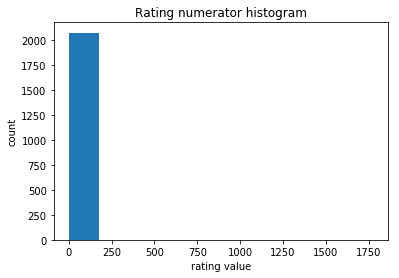

In [102]:
fig, ax = plt.subplots()
plt.hist(master_df.rating_numerator);
plt.title('Rating numerator histogram');
ax.set_ylabel('count');
ax.set_xlabel('rating value');

In [103]:
sample = master_df.rating_numerator.sample(300)


In [104]:
sample_means = np.random.choice(sample, size=(10000, 200)).mean(axis=1)
sample_means

array([ 11.665,  14.84 ,  13.8  , ...,  11.45 ,  13.45 ,  19.855])

Let's define a confidence interval for the mean of the rating_numerator using a bootstrapping method

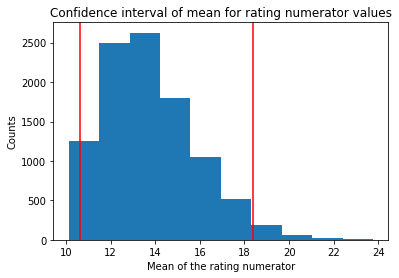

In [105]:
fig, ax = plt.subplots()
left, right = np.percentile(sample_means, 2.5), np.percentile(sample_means, 97.5), 
plt.hist(sample_means);
plt.title('Confidence interval of mean for rating numerator values')
ax.set_xlabel('Mean of the rating numerator');
ax.set_ylabel('Counts');
plt.axvline(left, color='r');
plt.axvline(right, color='r');

In [106]:
print("We can expect the mean of our population to be in between {} and {}".format(left, right))

We can expect the mean of our population to be in between 10.625 and 18.365


In [107]:
master_df.describe()

,tweet_id,rating_numerator,retweet_count,favorite_count,followers_count,conf_level
count,2.075000e+03,2075.000000,2056.000000,2056.000000,2.056000e+03,2075.000000
mean,7.384514e+17,12.266024,2341.959144,7342.061770,9.380289e+06,0.463269
std,6.785203e+16,40.680299,4092.509164,11106.592182,6.794392e+01,0.339216
min,6.660209e+17,0.000000,11.000000,0.000000,9.380275e+06,0.000000
25%,6.764835e+17,10.000000,496.750000,1395.500000,9.380276e+06,0.139761
50%,7.119988e+17,11.000000,1103.500000,3209.000000,9.380280e+06,0.457117
75%,7.932034e+17,12.000000,2696.250000,9129.750000,9.380282e+06,0.772790
max,8.924206e+17,1776.000000,69940.000000,143139.000000,9.380787e+06,0.999956


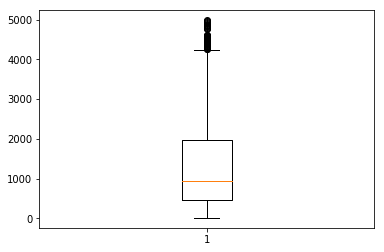

In [108]:
master_df = master_df[master_df.retweet_count < 5000].reset_index(drop = True)
plt.boxplot(master_df.retweet_count);

We can see that outliers are above 5000. Plot hist for values less then 5000:

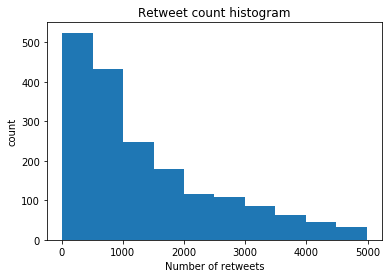

In [109]:
master_df = master_df[master_df.retweet_count < 5000].reset_index(drop = True)
fig, ax = plt.subplots()
plt.hist(master_df.retweet_count);
plt.title('Retweet count histogram');
ax.set_ylabel('count');
ax.set_xlabel('Number of retweets');

Calculate mean and standard deviation:

In [110]:
print('mean: {}, standard deviation: {}'.format(np.mean(master_df.retweet_count), np.std(master_df.retweet_count)))


mean: 1350.016393442623, standard deviation: 1171.3753262394218


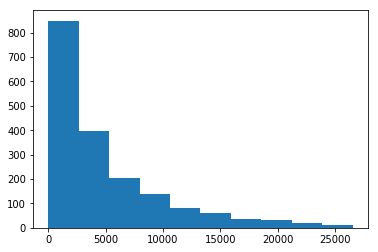

In [111]:
plt.hist(master_df.favorite_count);


plot hist of the favourite count

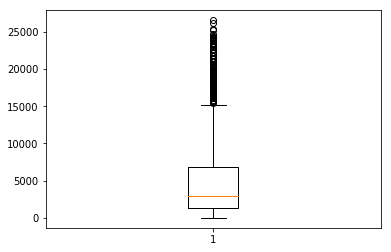

In [112]:
plt.boxplot(master_df.favorite_count.reset_index(drop = True));


Favourite count has outliers from 15000 

In [81]:
master_df = master_df[master_df.favorite_count < 16000]


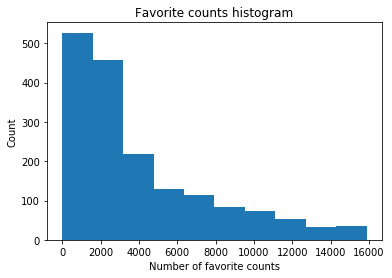

In [82]:
fig, ax = plt.subplots()
plt.hist(master_df.favorite_count);
plt.title('Favorite counts histogram');
ax.set_ylabel('Count');
ax.set_xlabel('Number of favorite counts');

In [83]:
print('mean: {}, standard deviation: {}'.format(np.mean(master_df.retweet_count), np.std(master_df.retweet_count)))


mean: 1210.3327536231884, standard deviation: 1037.8435672800558


correct mean and standard deviation

checking corelation between rating_numaretor and retweet_count

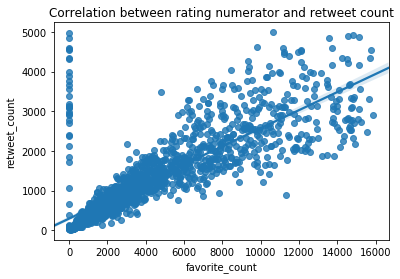

In [96]:
sns.regplot(master_df.favorite_count, master_df.retweet_count);
plt.title('Correlation between rating numerator and retweet count');

Favourite_count has 0 outliers 

In [97]:
master_df = master_df[master_df['favorite_count']!=0] 


In [13]:
sns.regplot(master_df.favorite_count, master_df.retweet_count);
plt.title('Correlation between rating numerator and retweet count');

NameError: name 'master_df' is not defined

as from the plot we can see we have a some correlation between favorite_count and retweet_count

Next I will look at the correlation between rating_numerator and retweet_count

In [ ]:
counts = [master_df.query('source == "Twitter for iPhone"').count()[0], master_df.query('source == "Vine"').count()[0],
          master_df.query('source == "Twitter Web Client"').count()[0], master_df.query('source == "TweetDeck"').count()[0]]
ind = np.arange(1, 5)
fig, ax = plt.subplots();
plt.bar(ind, counts);
ax.set_xticks(ind);

ax.set_ylabel('Counts');
ax.set_title('Source');

In [11]:
list(master_df)

NameError: name 'master_df' is not defined

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [12]:
master_df.to_csv('twitter_archive_master.csv', sep=';', index = False, encoding='utf-8', columns = ['tweet_id', 'source', 'text','expanded_urls' 'rating_numerator','name','jpl_url','retweet_count','favorite_count','followers_count', 'stage', 'dog_prediction','dog_count'])

NameError: name 'master_df' is not defined